## Part 1
Load the provided csv
Prepare the data as a time series DataFrame:
Melt the wide-form data into a long-form time series.
The date column should be named “Date”
The value column should be named “Home Value”
Convert the Date column to Datetime data type.
Set the Date column as the index
Prepare a copy of the data, which you will be saving for tableau, by filtering the data:
Keep data from the following states: CA, WA, OR, AZ, NV
Keep values from the years 2010 - 2020.
Save the processed data as a .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”
Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
Plot a line graph with each of the states as a separate line.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split


from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa



In [2]:

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

## Custom Functions

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [5]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r_squared = r2_score(y_true, y_pred)
    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
    if output_dict == True:
        metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
        return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)

    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train,results_test])
        # Set the label as the index 
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name=None
        # Return the dataframe
        return results_df.round(3)
    
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [6]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [7]:
##Load the data
df  = pd.read_csv("zillow_home_values-zipcode.csv", low_memory=False)
display(df.head())
df.info()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


In [8]:
#Melt the wide-form data into a long-form time series
#melted = pd.melt(df.drop(columns=['RegionID','SizeRank','RegionName','RegionType','StateName','City','Metro','CountyName']), 
  #               id_vars=['State'],
   #             value_name='HomeValue',var_name="Date")
melted = pd.melt(df.drop(columns=['RegionID','SizeRank','RegionType','StateName','Metro']), 
                 id_vars=['RegionName', 'State', 'CountyName', 'City' ],
                value_name='HomeValue',var_name="Date")
melted

,RegionName,State,CountyName,City,Date,HomeValue
0,77449,TX,Harris County,NaN,31012000,107261.0
1,77494,TX,Fort Bend County,NaN,31012000,222569.0
2,79936,TX,El Paso County,El Paso,31012000,90009.0
3,11368,NY,Queens County,New York,31012000,188096.0
4,11385,NY,Queens County,New York,31012000,275983.0
...,...,...,...,...,...,...
7546545,50160,IA,Warren County,Martensdale,30112022,193591.0
7546546,18081,PA,Bucks County,Hellertown,30112022,376523.0
7546547,55366,MN,Sibley County,NaN,30112022,110082.0
7546548,51009,IA,O Brien County,Calumet,30112022,75810.0


In [9]:
#Convert the Date column to Datetime data type.
melted['Date'] = pd.to_datetime(melted['Date'], format='%d%m%Y')
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   State       object        
 2   CountyName  object        
 3   City        object        
 4   Date        datetime64[ns]
 5   HomeValue   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 345.5+ MB


In [10]:
states = ( 'CA', 'WA', 'OR', 'AZ', 'NV')
melted = melted[melted['State'].isin(states)]
melted

,RegionName,State,CountyName,City,Date,HomeValue
5,90011,CA,Los Angeles County,Los Angeles,2000-01-31,143426.0
8,91331,CA,Los Angeles County,Los Angeles,2000-01-31,144841.0
9,90650,CA,Los Angeles County,Norwalk,2000-01-31,163955.0
12,90201,CA,Los Angeles County,Bell,2000-01-31,163273.0
13,92335,CA,San Bernardino County,Fontana,2000-01-31,110958.0
...,...,...,...,...,...,...
7546471,95950,CA,Colusa County,Grimes,2022-11-30,313005.0
7546504,89041,NV,Nye County,Pahrump,2022-11-30,414072.0
7546514,98623,WA,Klickitat County,White Salmon,2022-11-30,729920.0
7546515,98628,WA,Klickitat County,Goldendale,2022-11-30,146513.0


In [11]:
#Set the Date column as the index
melted = melted.set_index("Date")
melted['RegionName'] = melted['RegionName'].astype(str)
melted

,RegionName,State,CountyName,City,HomeValue
Date,,,,,
2000-01-31,90011,CA,Los Angeles County,Los Angeles,143426.0
2000-01-31,91331,CA,Los Angeles County,Los Angeles,144841.0
2000-01-31,90650,CA,Los Angeles County,Norwalk,163955.0
2000-01-31,90201,CA,Los Angeles County,Bell,163273.0
2000-01-31,92335,CA,San Bernardino County,Fontana,110958.0
...,...,...,...,...,...
2022-11-30,95950,CA,Colusa County,Grimes,313005.0
2022-11-30,89041,NV,Nye County,Pahrump,414072.0
2022-11-30,98623,WA,Klickitat County,White Salmon,729920.0


In [12]:
##  saving 2010-2020 values
melted1 = melted.loc['2010-01-01':'2020-12-31']
melted1

,RegionName,State,CountyName,City,HomeValue
Date,,,,,
2010-01-31,90011,CA,Los Angeles County,Los Angeles,209250.0
2010-01-31,91331,CA,Los Angeles County,Los Angeles,257372.0
2010-01-31,90650,CA,Los Angeles County,Norwalk,296430.0
2010-01-31,90201,CA,Los Angeles County,Bell,271829.0
2010-01-31,92335,CA,San Bernardino County,Fontana,156704.0
...,...,...,...,...,...
2020-12-31,95950,CA,Colusa County,Grimes,220881.0
2020-12-31,89041,NV,Nye County,Pahrump,NaN
2020-12-31,98623,WA,Klickitat County,White Salmon,538209.0


In [13]:
#Save the processed data as a .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”
melted1.to_csv('data-for-tableau.csv')

In [14]:
#Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
df_ts = melted1.groupby('State').resample("AS").mean()
df_ts

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23176\435938166.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = melted1.groupby('State').resample("AS").mean()


HomeValue
State Date                     
AZ    2010-01-01  169930.889076
      2011-01-01  152272.467002
      2012-01-01  159902.057789
      2013-01-01  183657.225403
      2014-01-01  198551.492521
      2015-01-01  206834.173937
      2016-01-01  217452.799614
      2017-01-01  229066.028099
      2018-01-01  244689.172792
      2019-01-01  257396.582183
      2020-01-01  278841.942045
CA    2010-01-01  415491.808100
      2011-01-01  388468.031550
      2012-01-01  388593.634299
      2013-01-01  454509.845597
      2014-01-01  505808.423831
      2015-01-01  535297.119658
      2016-01-01  569319.272450
      2017-01-01  601938.428066
      2018-01-01  646936.553061
      2019-01-01  649531.475923
      2020-01-01  675124.170696
NV    2010-01-01  189285.319787
      2011-01-01  168931.537037
      2012-01-01  165003.293888
      2013-01-01  199847.532946
      2014-01-01  228975.139535
      2015-01-01  247372.119614
      2016-01-01  265123.976834
      2017-01-01  284543.217949
      2018-01-01  319753.462629
      2019-01-01  337914.425207
      2020-01-01  350564.885423
OR    2010-01-01  224035.019849
      2011-01-01  205273.042225
      2012-01-01  201899.022119
      2013-01-01  216964.502931
      2014-01-01  233022.531108
      2015-01-01  249633.916898
      2016-01-01  272424.454568
      2017-01-01  294524.759060
      2018-01-01  311491.056020
      2019-01-01  323800.937928
      2020-01-01  338782.970027
WA    2010-01-01  250932.487018
      2011-01-01  230557.026098
      2012-01-01  225432.142832
      2013-01-01  240848.444598
      2014-01-01  256869.916239
      2015-01-01  275704.942220
      2016-01-01  302116.532078
      2017-01-01  334494.267926
      2018-01-01  367370.462736
      2019-01-01  381711.638949
      2020-01-01  408430.209929

In [15]:
df_backup = df_ts.copy()

In [16]:
CA_ts = df_ts.loc['CA','HomeValue']
WA_ts = df_ts.loc['WA','HomeValue']
OR_ts = df_ts.loc['OR','HomeValue']
NV_ts = df_ts.loc['NV','HomeValue']
AZ_ts = df_ts.loc['AZ','HomeValue']

In [17]:
compare_ts = pd.DataFrame({'CA':CA_ts,
                          'WA':WA_ts,
                          'OR':OR_ts,
                          'NV':NV_ts,
                          'AZ':AZ_ts})
compare_ts


,CA,WA,OR,NV,AZ
Date,,,,,
2010-01-01,415491.808100,250932.487018,224035.019849,189285.319787,169930.889076
2011-01-01,388468.031550,230557.026098,205273.042225,168931.537037,152272.467002
2012-01-01,388593.634299,225432.142832,201899.022119,165003.293888,159902.057789
2013-01-01,454509.845597,240848.444598,216964.502931,199847.532946,183657.225403
2014-01-01,505808.423831,256869.916239,233022.531108,228975.139535,198551.492521
2015-01-01,535297.119658,275704.942220,249633.916898,247372.119614,206834.173937
2016-01-01,569319.272450,302116.532078,272424.454568,265123.976834,217452.799614
2017-01-01,601938.428066,334494.267926,294524.759060,284543.217949,229066.028099
2018-01-01,646936.553061,367370.462736,311491.056020,319753.462629,244689.172792


In [18]:
str_fmt = mticks.StrMethodFormatter("{x:,.0f}")
str_fmt

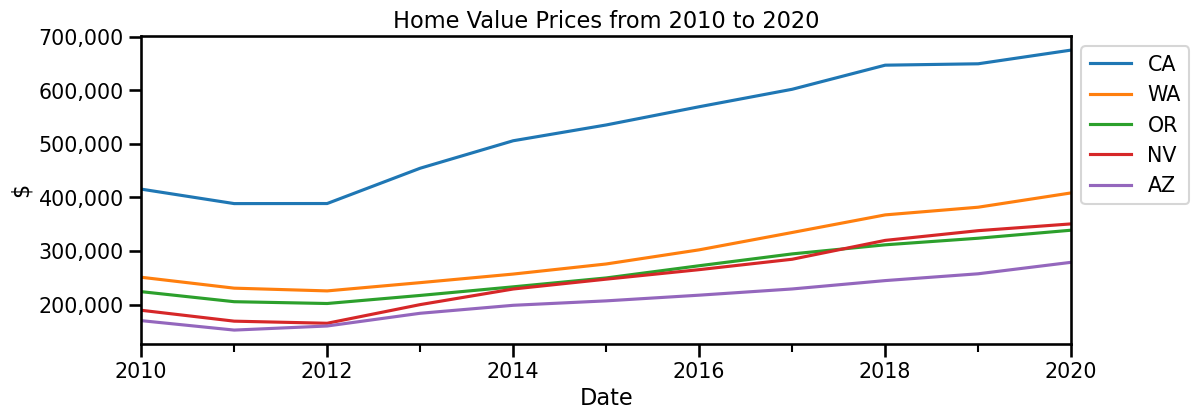

In [19]:
ax = compare_ts.plot(title='Home Value Prices from 2010 to 2020',ylabel='$');
ax.yaxis.set_major_formatter(str_fmt)
ax.legend();
ax.legend(bbox_to_anchor=[1,1]);

## Part 2
Filter the data and transform the data to obtain a time series of the mean value of home prices for the month
State of Oregon (OR)
Monthly mean
Keep dates from 2000-01-31 through 2018-12-31

In [20]:
df_OR = melted.groupby('State').resample("M").mean();
df_OR;

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23176\2945321442.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_OR = melted.groupby('State').resample("M").mean();
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23176\2945321442.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_OR = melted.groupby('State').resample("M").mean();
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23176\2945321442.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should 

In [21]:
df_OR = df_OR.loc['OR'].copy()
df_OR

,HomeValue
Date,
2000-01-31,162508.613445
2000-02-29,162913.172269
2000-03-31,163011.125523
2000-04-30,163541.908333
2000-05-31,164176.420833
...,...
2022-07-31,461233.035813
2022-08-31,461219.498623
2022-09-30,461302.785124


In [22]:
##  saving 2010-2020 values
df_OR = df_OR.loc['2000-01-31':'2018-12-31']
df_OR

,HomeValue
Date,
2000-01-31,162508.613445
2000-02-29,162913.172269
2000-03-31,163011.125523
2000-04-30,163541.908333
2000-05-31,164176.420833
...,...
2018-08-31,313844.697059
2018-09-30,315055.305882
2018-10-31,316216.785294


In [23]:
#check for null values
df_OR.isna().sum()

HomeValue    0
dtype: int64

In [24]:
# Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not

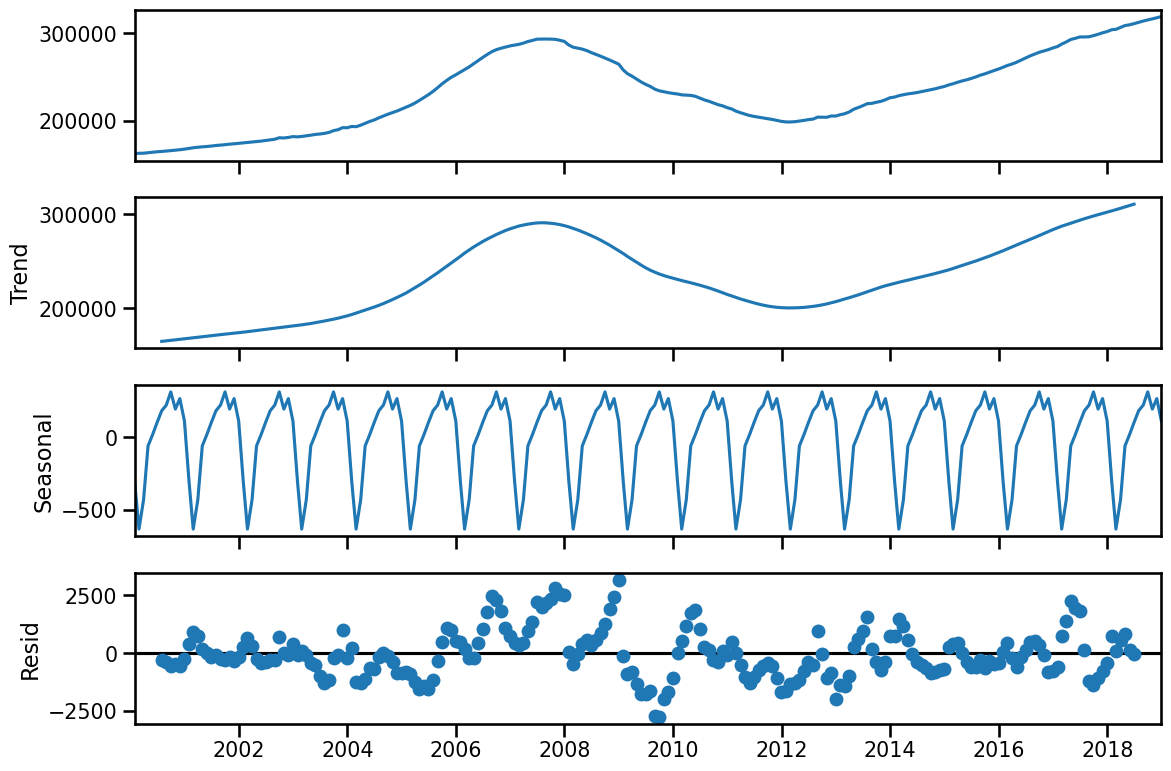

In [25]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(df_OR)

#plot
fig = decomp.plot()
fig.set_size_inches(12,8)
fig.tight_layout()

In [26]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min();

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(df_OR.max()-df_OR.min()) * 100}% of the variation in time series.");

The seasonal component is  948.43 which is ~HomeValue    0.605962
dtype: float64% of the variation in time series.


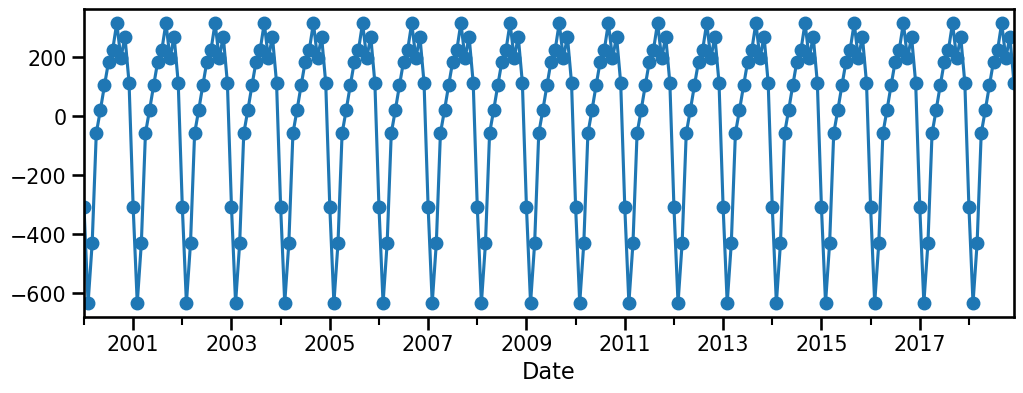

In [27]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal

#plot
ax = seasonal.loc['2000-01-31':'2018-12-31'].plot(marker = 'o');

In [28]:
# Testing the raw data for stationarity
get_adfuller_results(df_OR)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.786015,3,224,0.387427,0.05,False


In [29]:
d = ndiffs(df_OR)
print(f'd = {d}')

d = 2


In [30]:
# Determine D
D = nsdiffs(df_OR, m=12)
# nsdiffs = function used to analyze ts data for seasonal patterns(patterns = trends that repeat at regular interval)
print(f'D = {D}')

D = 0


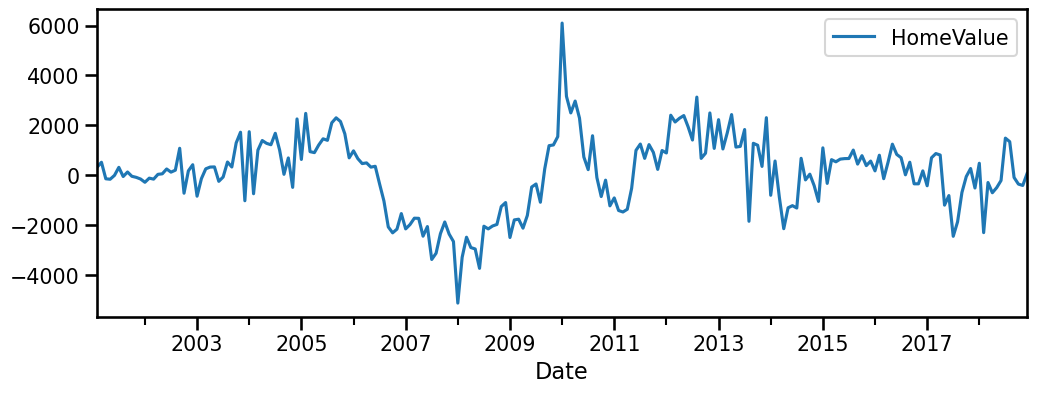

In [31]:
# apply both differencings
df_OR_diff = df_OR.diff().diff(12).dropna()

#create the plot
fig, ax = plt.subplots()
df_OR_diff.plot(ax = ax);

Use the ACF and PACF plots of stationarity data to estimate initial orders

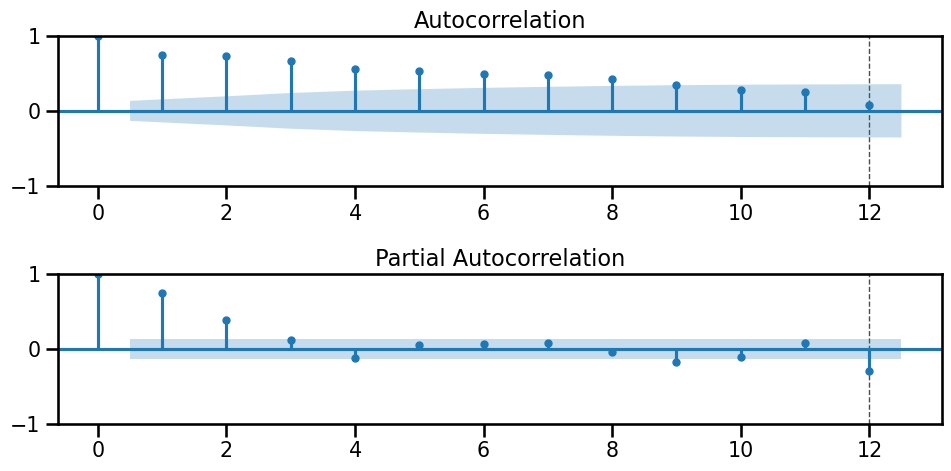

In [32]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(df_OR_diff, 
              annotate_seas = True, 
              m =12, 
              nlags =12, 
              pacf_kws = {'method':'ywm'});

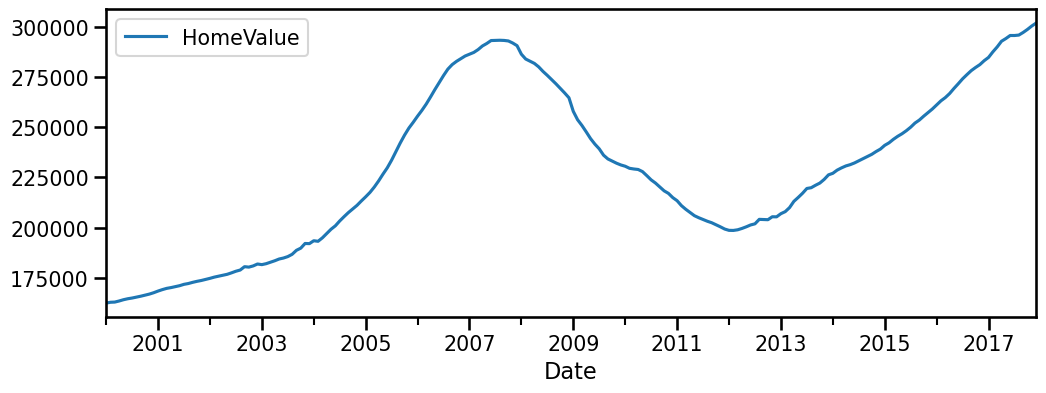

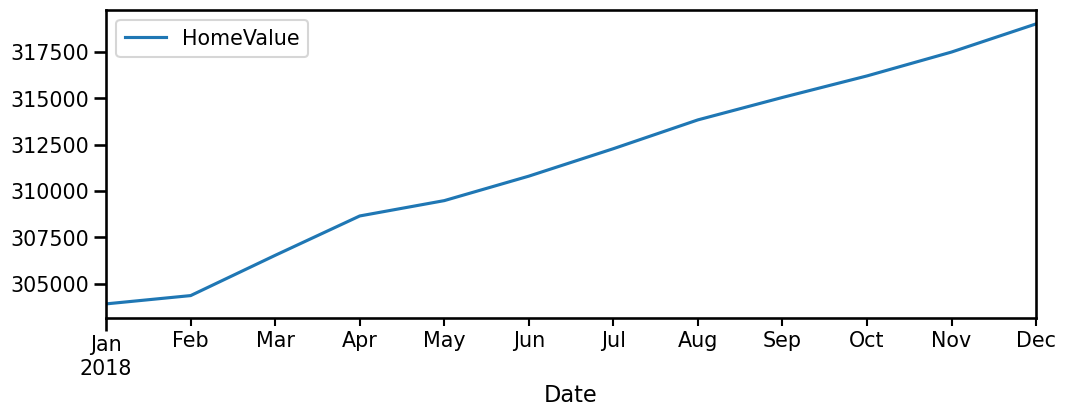

In [33]:
#Split the time series into training and test data (Remember we want to predict 12 months)

# tts--goal is to predict next year so 12 months
nlags = 12 # this is for the next 12 months
train, test = train_test_split(df_OR, test_size = nlags)

#plot
ax = train.plot(label = 'Train')
test.plot(label = 'Test')
ax.legend();

In [34]:
# Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
# Initial model

# Orders for non seasonal components
p =  2 # nonseasonal AR
d =  2 # nonseasonal differencing
q =  0 # nonseasonal MA

# Orders for seasonal components
P =  0 # Seasonal AR
D =  0 # Seasonal differencing
Q =  1 # Seasonal MA
m =  12 # Seasonal period

model_1 = tsa.ARIMA(train, order = (p,d, q), seasonal_order = (P,D,Q,m)).fit() 

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 376.138
- MSE = 193,905.802
- RMSE = 440.347
- R^2 = 0.992
- MAPE = 0.12%


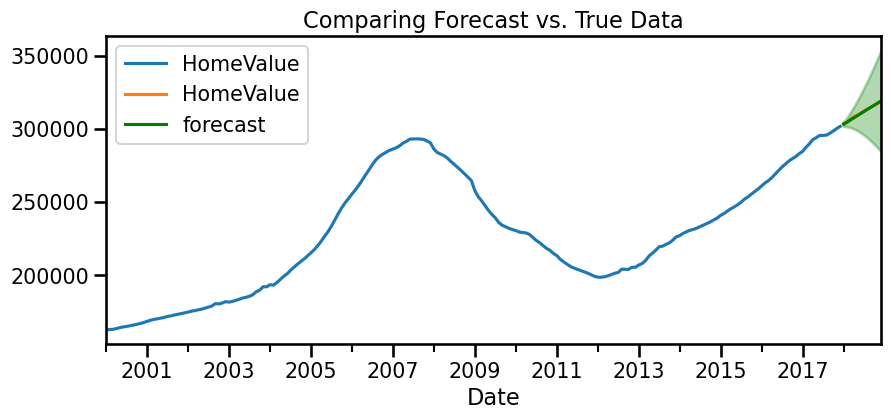

In [35]:
# Obtain summary of forecast as dataframe
forecast_df = model_1.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])
#MAPE < 5% excellent, 5-10% VG, 10-20% good, 20-50% fair, >50% bad

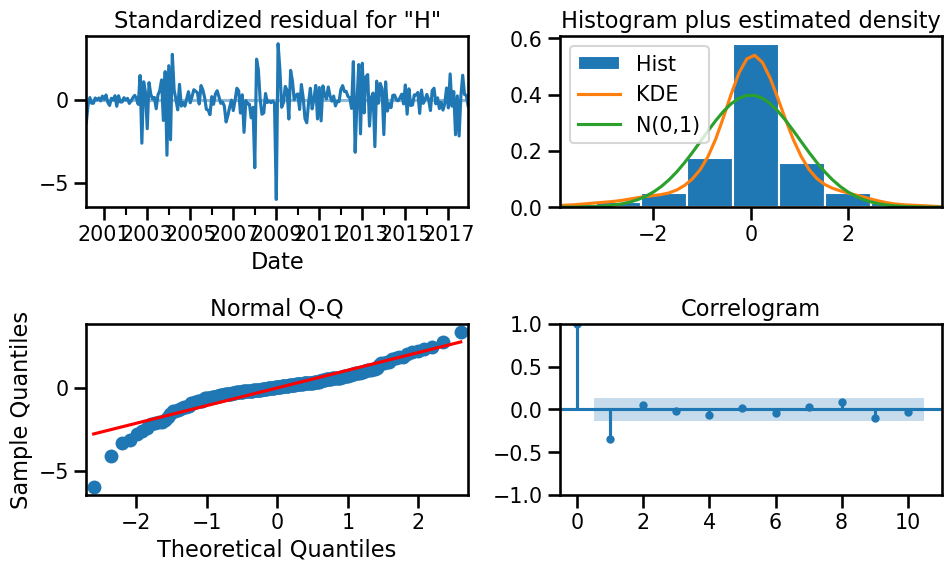

In [36]:
# Obtain diagnostic plots
fig = model_1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

In [37]:
# Obtain summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          HomeValue   No. Observations:                  216
Model:             ARIMA(2, 2, 0)x(0, 0, [1], 12)   Log Likelihood               -1725.839
Date:                            Fri, 05 Apr 2024   AIC                           3459.678
Time:                                    20:58:01   BIC                           3473.141
Sample:                                01-31-2000   HQIC                          3465.118
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0199      0.017     -1.187      0.235      -0.053       0.013
ar.L2         -0.0140      0.036     -0.383      0.701      -0.085       0.057
ma.S.L12       0.0069      0.035      0.198      0.843      -0.061       0.075
sigma2      5.112e+05   2.65e+04     19.318      0.000    4.59e+05    5.63e+05
===================================================================================
Ljung-Box (L1) (Q):                  26.65   Jarque-Bera (JB):               359.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -1.16
Prob(H) (two-sided):                  0.26   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
##Tune with pmdarima's auto_arima
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(train,
                           seasonal= True,
                           m=12,
                           trace =True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4017.020, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3822.254, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3823.629, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3816.219, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3848.225, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3817.779, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3818.217, Time=0.21 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3817.994, Time=0.42 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3816.230, Time=0.22 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3819.930, Time=0.68 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3820.431, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3798.245, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3798.383, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,1)(0,0,2)[12]

In [39]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 0, 12)


In [40]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1888.586
Date:                Fri, 05 Apr 2024   AIC                           3783.172
Time:                        20:58:16   BIC                           3793.284
Sample:                    01-31-2000   HQIC                          3787.257
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9386      0.020     48.067      0.000       0.900       0.977
ma.L1         -0.9074      0.022    -40.482      0.000      -0.951      -0.863
sigma2      2.245e+06   5.06e-10   4.44e+15      0.000    2.24e+06    2.24e+06
===================================================================================
Ljung-Box (L1) (Q):                 160.38   Jarque-Bera (JB):                27.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.72
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.61e+31. Standard errors may be unstable.
"""

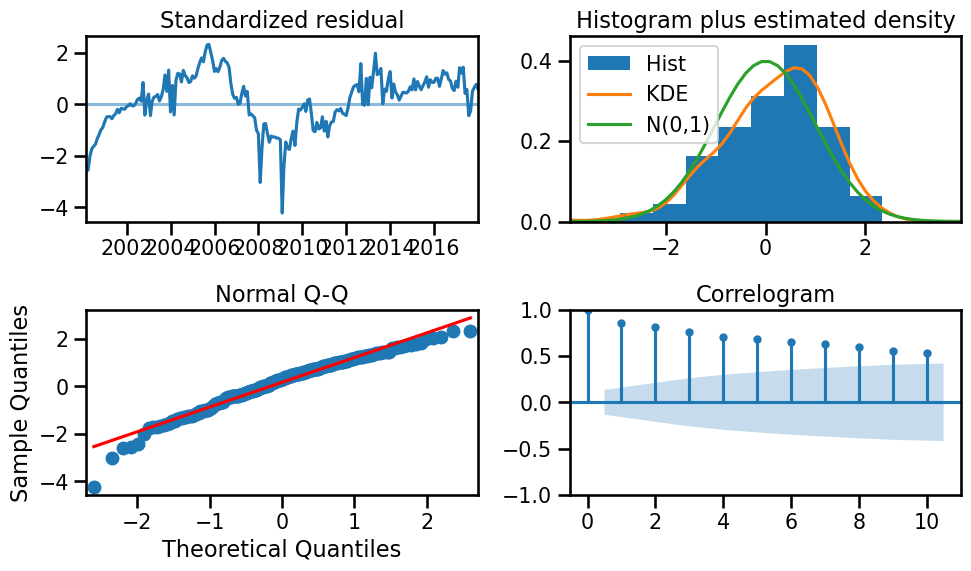

In [41]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 6,888.612
- MSE = 60,135,147.913
- RMSE = 7,754.686
- R^2 = -1.583
- MAPE = 2.19%


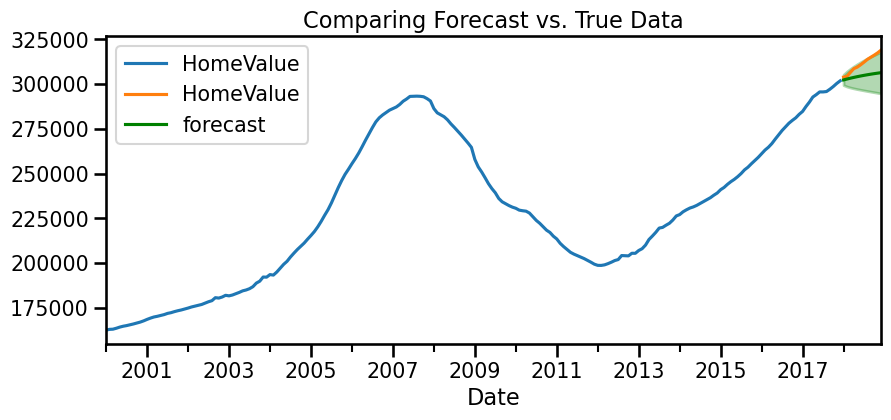

In [42]:
# Use auto_arima parameters to fit an ARIMA
model_2 = tsa.ARIMA(train, 
                  order = auto_model.order,
                  seasonal_order = auto_model.seasonal_order).fit()

# Obtain forecast as a dataframe with confidence intervals
forecast_df = model_2.get_forecast(steps = len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

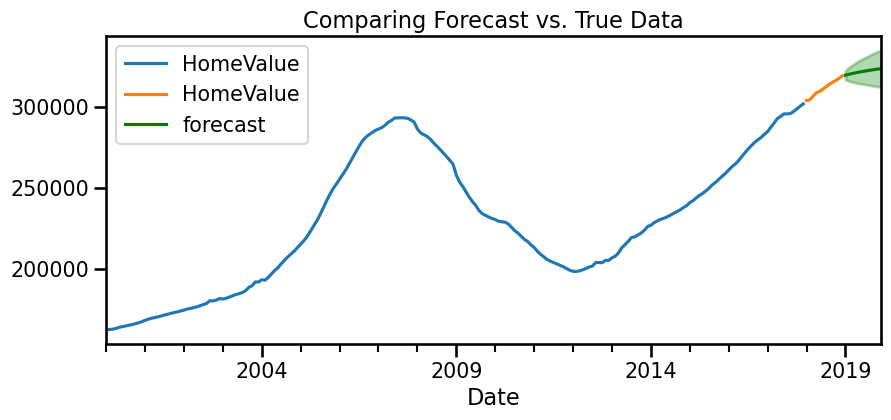

In [43]:
# Use auto_arima parameters to fit an ARIMA
final_model = tsa.ARIMA(df_OR, 
                  order = auto_model.order,
                  seasonal_order = auto_model.seasonal_order).fit()


# Obtain future forecasts beyond test data
forecast_df = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_df, n_train_lags = 0)

In [44]:
# Forecast mean:
forecast_df['mean']

2019-01-31    319535.992911
2019-02-28    320017.483722
2019-03-31    320470.875627
2019-04-30    320897.808423
2019-05-31    321299.826217
2019-06-30    321678.383000
2019-07-31    322034.847914
2019-08-31    322370.510199
2019-09-30    322686.583858
2019-10-31    322984.212047
2019-11-30    323264.471208
2019-12-31    323528.374967
Freq: M, Name: mean, dtype: float64

In [45]:
# Month with Maximum popularity forecasted for next year
forecast_df['mean'].idxmax()

Timestamp('2019-12-31 00:00:00', freq='M')

In [46]:
# Month with Minmum popularity next year
forecast_df['mean'].idxmin()

Timestamp('2019-01-31 00:00:00', freq='M')

In [47]:
# Final model
#The metrics for the initial model and auto model are similar. 
#We choose the auto arima model because it had a slightly lower AIC and BIC, reduced significant correlations in the residuals, and the additional coefficients were significant.

## Part 3
tableau workbook

https://public.tableau.com/app/profile/paul.jerome.carreon/viz/JCarreon-BeltExam4/StoryPoint1MedianHomeValuebyLocations?publish=yes